In [ ]:
# !pip install torchtext
!pip install -U torchtext==0.10.0
!pip install konlpy
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torchtext.legacy import data 
from torchtext.legacy.data import TabularDataset, Iterator
from torchtext.vocab import Vectors
from sklearn.model_selection import StratifiedKFold, train_test_split
from konlpy.tag import Okt
from google.colab import drive, files
import csv
import urllib.request
from tqdm.notebook import tqdm
import gensim
from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors

# This is for debugging 
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# CPU / GPU
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Device is:", DEVICE)

# Load dataset
train = pd.read_csv('/content/drive/MyDrive/CS376_project/train.csv', header=0) # train set
test = pd.read_csv('/content/drive/MyDrive/CS376_project/test.csv', header=0) # test set

# train.head()

tokenizer = Okt() # Konlpy's Okt tokneizer (= twitter tokenizer in past)

# Build torchtext fields
TEXT = data.Field(sequential=True,
                  use_vocab=True,
                  tokenize=tokenizer.pos, # Use Konlpy Okt as a tokenizer
                  #lower=True,
                  batch_first=True,
                  fix_length=44)

LABEL = data.Field(sequential=False,
                   use_vocab=False,
                   is_target=True)

# 5-fold validation
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

for i, (trn_idx,val_idx) in enumerate(skf.split(train['text'], train['translated'])):
    trn = train.iloc[trn_idx]
    val = train.iloc[val_idx]

trn.to_csv('trn.csv',index = False)
val.to_csv('val.csv',index = False)
test.to_csv('test.csv',index = False)

# Build Iterators for training
train_data, validation_data, test_data = TabularDataset.splits(
    path='', train='trn.csv',validation= 'val.csv', test='test.csv', format='csv', fields=[('text', TEXT), ('label', LABEL)], skip_header=True)

train_iter = Iterator(dataset = train_data, batch_size = BATCH_SIZE)
val_iter = Iterator(dataset = validation_data, batch_size = BATCH_SIZE)
test_iter = Iterator(dataset = test_data, batch_size = BATCH_SIZE,shuffle = False)

print('Training set size: {}'.format(len(train_data)))
print('Validation set size : {}'.format(len(validation_data)))
print('Test set size : {}'.format(len(test_data)))

print('Train data minibatch size : {}'.format(len(train_iter)))
print('Validation data minibatch size : {}'.format(len(val_iter)))
print('Test data minibatch size : {}'.format(len(test_iter)))

Device is: cuda


In [ ]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.0005
EPOCHS = 75

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Convert train data dataframe into list for preprocessing
train_sentence_list = train['text'].tolist()
print(train_sentence_list[:5])

print_count = 5
print_counter = 0

# Tokenize train data to build word2vec vector 
token_string_list = []

for line in train_sentence_list:

    # Proper sentences are in type string. Discard the others.
    if not isinstance(line, str):
      continue

    # Tokenize each sentence(=line) with Okt().pos. token is tuple of strings (morpheme, pos tag) e.g. ('는', 'Josa') 
    token_list = tokenizer.pos(line, norm=True, stem=True)
    r = []

    for token in token_list:

      # Do not process 조사(Josa), 어미(Eomi), Punctuation 
      if not token[1] in ["Josa","Eomi","Punctuation"]:
          r.append('(\'' + '\',\''.join(word) + '\')')

    token_string_list += r

    # Print result print_count times
    if print_counter < print_count:
      print(r)
    print_counter += 1

# 형태소들을 별도의 파일로 저장 합니다.
# with open('pos_vec_target','w', encoding='utf-8') as fp:
#     fp.write("\n".join(result))

# Word2Vec Model Training
# W2V_SIZE = 200
# W2V_MIN_COUNT = 2
# wData = word2vec.LineSentence('pos_vec_target')
# w2v_model = word2vec.Word2Vec(wData, size=W2V_SIZE, window=5, hs=1, min_count=W2V_MIN_COUNT, sg=1)
# w2v_model.save('pos_vec_target')
# print("Word2Vec Modeling finished")

# print(w2v_model['(\'지역\',\'Noun\')'])

# files.download('pos_vec_target')

In [ ]:
# Save token list as a file
with open('token_list.txt','w', encoding='utf-8') as fp:
    fp.write("\n".join(token_string_list))

# files.download('token_list.txt')

In [ ]:
W2V_SIZE = 200
W2V_MIN_COUNT = 2

# Load pre-trained word2vc Korean morpheme vectors
pretrained_vectors_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/CS376_project/pos.vec', binary=False)
pretrained_vectors_model.save('pos_vec')

# w2v_model.build_vocab([list(pretrained_vectors_model.vocab.keys())], update = True)
# w2v_model.intersect_word2vec_format('pos.vec', binary=False)

# Build new word2vec model
w2v_model = word2vec.Word2Vec(size=W2V_SIZE, window=10, hs=1, min_count=W2V_MIN_COUNT, sg=1)

# print(list(pretrained_vectors_model.vocab.keys())[:5])
# print(token_string_list[:5])

w2v_model.build_vocab([token_string_list])

# print(w2v_model.wv.vocab.keys())

total_examples = w2v_model.corpus_count

w2v_model.build_vocab([list(pretrained_vectors_model.vocab.keys())], update = True)
w2v_model.intersect_word2vec_format('/content/drive/MyDrive/CS376_project/pos.vec', binary=False)
w2v_model.train(token_string_list, total_examples=total_examples, epochs=w2v_model.iter)

["('을','Josa')", "('에','Josa')", "('의','Josa')", "('이','Josa')", "('를','Josa')"]
["('잠정','Noun')", "('합의','Noun')", "('안다','Verb')", "('지역','Noun')", "('노동계','Noun')"]
dict_keys(["('잠정','Noun')", "('합의','Noun')", "('안다','Verb')", "('지역','Noun')", "('노동계','Noun')", "('주장','Noun')", "('이','Noun')", "('조항','Noun')", "('5년','Number')", "('간','Foreign')", "('또는','Adverb')", "('35만','Number')", "('대','Foreign')", "('생산','Noun')", "('때','Noun')", "('임','Noun')", "('유예','Noun')", "('의미','Noun')", "('하다','Verb')", "('것','Noun')", "('아니다','Adjective')", "('내용','Noun')", "('추가','Noun')", "('알려지다','Verb')", "('시','Noun')", "('오다','Verb')", "('2020년','Number')", "('새롭다','Adjective')", "('추진','Noun')", "('되다','Verb')", "('인천','Noun')", "('복지','Noun')", "('재단','Noun')", "('내','Noun')", "('탈','Noun')", "('시설','Noun')", "('전환','Noun')", "('원','Modifier')", "('팀','Noun')", "('설치','Noun')", "('가칭','Noun')", "('센터','Noun')", "('설립','Noun')", "('예정','Noun')", "('철도공사','Noun')", "('이번','Noun')", "('프로젝트','N

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


(0, 11850450)

In [ ]:
# vocab = list(pretrained_vectors_model.vocab.keys()) # Word2Vec에서 사용한 vocab

# pretrained_vectors=[]
# for vo in vocab:
#     pretrained_vectors.append(pretrained_vectors_model[vo])
    
# pretrained_vectors = np.vstack(pretrained_vectors)
# vectors = Vectors(name='pos_vec')

TEXT.build_vocab(train_data,
                 min_freq = W2V_MIN_COUNT, 
                 max_size = 20000,
                 )

word2vec_vectors = []
total = 0
counter = 0
W2V_SIZE = 200

for token, idx in tqdm(TEXT.vocab.stoi.items()):
    total += 1
    token = '(\'' + '\',\''.join(token) + '\')'
    if total < 20 :
      print(type(token), token)
    # if token in list(pretrained_vectors_model.vocab.keys()):
    #     word2vec_vectors.append(torch.FloatTensor(pretrained_vectors_model[token]))
    if token in list(w2v_model.wv.vocab.keys()):
        word2vec_vectors.append(torch.FloatTensor(w2v_model[token]))        
    else:
        word2vec_vectors.append(torch.zeros(W2V_SIZE))
        counter += 1

TEXT.vocab.set_vectors(TEXT.vocab.stoi, word2vec_vectors, W2V_SIZE)
pre_trained_emb = torch.FloatTensor(TEXT.vocab.vectors)

print('Vocab size : {}'.format(len(TEXT.vocab)))
print(counter, '/', total)

훈련 샘플의 개수 : 5326
검증 샘플의 개수 : 1331
테스트 샘플의 개수 : 1665


In [ ]:
print(type(list(pretrained_vectors_model.vocab.keys())[0]))
# print(pretrained_vectors_model('(\'을\',\'Josa\')'))

In [ ]:
# train_data, validation_data, test_data = TabularDataset.splits(
#      path='', train='trn.csv',validation= 'val.csv', test='test.csv', format='csv',
#         fields=[('text', TEXT), ('label', LABEL)], skip_header=True)

# print('훈련 샘플의 개수 : {}'.format(len(train_data)))
# print('검증 샘플의 개수 : {}'.format(len(validation_data)))
# print('테스트 샘플의 개수 : {}'.format(len(test_data)))

# TEXT.build_vocab(train_data,
#                  min_freq = W2V_MIN_COUNT, 
#                  max_size = 20000,
#                  vector = vectors
#                  )

# word2vec_vectors = []
# total = 0
# counter = 0

# for token, idx in tqdm(TEXT.vocab.stoi.items()):
#     total += 1
#     if token in wModel.wv.vocab.keys():
#         word2vec_vectors.append(torch.FloatTensor(wModel[token]))
#     else:
#         word2vec_vectors.append(torch.zeros(W2V_SIZE))
#         counter += 1

# TEXT.vocab.set_vectors(TEXT.vocab.stoi, word2vec_vectors, W2V_SIZE)
# pre_trained_emb = torch.FloatTensor(TEXT.vocab.vectors)

# print('단어 집합의 크기 : {}'.format(len(TEXT.vocab)))

# train_iter = Iterator(dataset = train_data, batch_size = BATCH_SIZE)
# val_iter = Iterator(dataset = validation_data, batch_size = BATCH_SIZE)
# test_iter = Iterator(dataset = test_data, batch_size = BATCH_SIZE,shuffle = False)

# print('훈련 데이터의 미니 배치 수 : {}'.format(len(train_iter)))
# print('검증 데이터의 미니 배치 수 : {}'.format(len(val_iter)))
# print('테스트 데이터의 미니 배치 수 : {}'.format(len(test_iter)))

# print(counter, '/', total)

In [ ]:
vocab_size = len(TEXT.vocab)
n_classes = 2 

In [ ]:
# Blocks
class DenseBlock(nn.Module):
    def __init__(self, in_dim, out_dim, softmax = False):
      super(DenseBlock, self).__init__()
      self.dense = nn.Linear(in_dim, out_dim) # dense layer
      self.act = nn.Softmax(dim=1) if softmax else nn.ReLU() # activation function

    def forward(self, x):
      x =  self.dense(x)
      out = self.act(x)
      return out

# Model
class Detector(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(Detector, self).__init__()
        print("Building Detector...")
        self.n_layers = n_layers 
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout_p)

        # Embedding Modes : Unblock one of the follwing two lines and block the other. 
        self.embed = nn.Embedding(n_vocab, embed_dim) # without pre-trained word2vec           
        # self.embed = nn.Embedding.from_pretrained(pre_trained_emb) # with pre-trained word2vec

        self.gru = nn.GRU(embed_dim, self.hidden_dim,
                          num_layers = self.n_layers,
                          batch_first = True)
        self.dense = DenseBlock(self.hidden_dim, self.hidden_dim)
        self.out = DenseBlock(self.hidden_dim, n_classes, True)

    def forward(self, x):
        
        # Embedding layer
        x = self.dropout(self.embed(x))      
  
        # GRU layer
        h_0 = self._init_state(batch_size=x.size(0)) # Initialize hidden vector as zero vector
        x, _ = self.gru(x, h_0)  # x : (batch_size, input length, hidden_dim)
        x = x[:,-1,:] # x : (batch_size, 1, hidden_dim), last hidden state in each batch
        x = self.dropout(x) 

        # Linear layers 
        x = self.dropout(self.dense(x))
        x = self.dropout(self.dense(x))
        x = self.dropout(self.dense(x)) # Block: GRU-2(2 linear layers). Unblock : GRU-3(3 linear layers)
        
        # Output layer
        logit = self.out(x) # ((batch_size, hidden_dim) -> (batch_size, out_dim)
        return logit
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()


def train(model, optimizer, train_iter):
    model.train()

    for b, batch in enumerate(train_iter):
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        optimizer.zero_grad() 
        logit = model(x) # Predicted logit
        loss = F.cross_entropy(logit, y) # Cross entropy
        loss.backward()
        optimizer.step()

def evaluate(model, val_iter):    
    model.eval()
    corrects, total_loss = 0, 0

    for batch in val_iter: 
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        logit = model(x) # Predicted logit
        loss = F.cross_entropy(logit, y, reduction='sum') # Cross entropy
        total_loss += loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size

    return avg_loss, avg_accuracy

In [ ]:
EMB_DIM = 100
HIDDEN_DIM = 256
DROPOUT = 0.5

model = Detector(1, HIDDEN_DIM, vocab_size, EMB_DIM, n_classes, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

best_val_loss = None

with open('result.txt','w', encoding='utf-8') as fp:
  fp.write("Title\n")
  for e in range(1, EPOCHS+1):
      train(model, optimizer, train_iter)
      val_loss, val_accuracy = evaluate(model, val_iter)
      test_loss, test_acc = evaluate(model, test_iter)

      print("[Epoch: %d] Val. loss:%5.2f | Val. acc:%5.2f" % (e, val_loss, val_accuracy))
      print('Test loss: %5.2f | Tess acc: %5.2f' % (test_loss, test_acc))
      fp.write("%d, %5.2f, %5.2f,\n" % (e, val_loss, val_accuracy))

      # Save best model with least validation loss
      if not best_val_loss or val_loss < best_val_loss:
          if not os.path.isdir("snapshot"):
              os.makedirs("snapshot")
          torch.save(model.state_dict(), './snapshot/txtclassification.pt')
          best_val_loss = val_loss

  model.load_state_dict(torch.load('./snapshot/txtclassification.pt'))
  test_loss, test_acc = evaluate(model, test_iter)

  print('Test loss: %5.2f | Test acc: %5.2f' % (test_loss, test_acc))
  fp.write("test, %5.2f, %5.2f,\n" % (test_loss, test_acc))

files.download('result.txt')

Building Detector...
[Epoch: 1] Val. loss: 0.69 | Val. acc:51.31
Test loss:  0.69 | Tess acc: 49.19
[Epoch: 2] Val. loss: 0.69 | Val. acc:49.59
Test loss:  0.69 | Tess acc: 52.67
[Epoch: 3] Val. loss: 0.68 | Val. acc:66.04
Test loss:  0.68 | Tess acc: 67.99
[Epoch: 4] Val. loss: 0.59 | Val. acc:71.00
Test loss:  0.57 | Tess acc: 73.27
[Epoch: 5] Val. loss: 0.58 | Val. acc:72.65
Test loss:  0.56 | Tess acc: 74.83
[Epoch: 6] Val. loss: 0.59 | Val. acc:71.83
Test loss:  0.57 | Tess acc: 74.59
[Epoch: 7] Val. loss: 0.64 | Val. acc:67.09
Test loss:  0.64 | Tess acc: 67.45
[Epoch: 8] Val. loss: 0.62 | Val. acc:69.12
Test loss:  0.61 | Tess acc: 69.19
[Epoch: 9] Val. loss: 0.54 | Val. acc:76.41
Test loss:  0.52 | Tess acc: 78.56
[Epoch: 10] Val. loss: 0.54 | Val. acc:77.08
Test loss:  0.52 | Tess acc: 79.16
[Epoch: 11] Val. loss: 0.54 | Val. acc:76.63
Test loss:  0.52 | Tess acc: 78.86
[Epoch: 12] Val. loss: 0.54 | Val. acc:77.08
Test loss:  0.52 | Tess acc: 78.80
[Epoch: 13] Val. loss: 0.53 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.load_state_dict(torch.load('./snapshot/txtclassification.pt'))
test_loss, test_acc = evaluate(model, test_iter)
print('Test loss: %5.2f | Tess acc: %5.2f' % (test_loss, test_acc))

Test loss:  0.63 | Tess acc: 64.98


In [ ]:
# #### Garbage ####

# import os
# from torchtext.legacy import data, datasets
# # 데이터 로딩하기
# print("데이터 로딩중...")

# # data.Field 설명 #
# # sequential인자 : TEXT는 Sequential 데이터라 True, Lable은 비Sequential이라 False로 설정
# # batch_first : Batch를 우선시 하여, Tensor 크기를 (BATCH_SIZE, 문장의 최대 길이)로 설정
# # lower : 소문자 전환 인자
# # # # # # # # # # #
# TEXT = data.Field(sequential=True, batch_first=True, lower=True)
# LABEL = data.Field(sequential=False, batch_first=True)

# #IMDB 데이터 로딩
# trainset, testset = datasets.IMDB.splits(TEXT, LABEL)

# # data.Field.build_vocab() 라이브러리
# # 문장 내 단어와 Integer index 를 매칭시키는 단어장(vocab)을 생성 == 워드 임베딩을 위한 Vocab 생성
# # <UNK> = 0, <PAD> = 1 토큰도 추가.
# # min_freq : 최소 5번 이상 등장한 단어들만 사전에 담겠다는 것. 
# # 5번 미만으로 등장하는 단어는 UNK라는 토큰으로 대체
# TEXT.build_vocab(trainset, min_freq=5)# TEXT 데이터를 기반으로 Vocab 생성
# LABEL.build_vocab(trainset)# LABEL 데이터를 기반으로 Vocab 생성


# # 학습용 데이터를 학습셋 80% 검증셋 20% 로 나누기
# trainset, valset = trainset.split(split_ratio=0.8)
# # 매 배치마다 비슷한 길이에 맞춰 줄 수 있도록 iterator 정의
# train_iter, val_iter, test_iter = data.BucketIterator.splits(
#         (trainset, valset, testset), batch_size=BATCH_SIZE,
#         shuffle=True, repeat=False)


# vocab_size = len(TEXT.vocab)
# n_classes = 2 
# # Positive, Negative Class가 두 개

# '''
# # Test #
# for batch in train_iter:
#     print(batch.text)
#     print(batch.label)
#     break
# '''     

# print("[학습셋]: %d [검증셋]: %d [테스트셋]: %d [단어수]: %d [클래스] %d"
#       % (len(trainset),len(valset), len(testset), vocab_size, n_classes))


# General corpus : Naver Movie sentiment corpus
# urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")
# corpus_general = pd.DataFrame(pd.read_table('ratings.txt')['document']).dropna(how = 'any')
# corpus_general.columns = ['text']
# corpus_general['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# # Target corpus : target sentences
# corpus_target = pd.DataFrame(pd.concat([train, test])['text'])
# print(corpus_general[:5], corpus_target[:5])

# # Merge general corpus with target corpus
# corpus = pd.concat([corpus_general, corpus_target])
# print(corpus[:5])

In [ ]:
df_data = pd.read_csv('google.txt', sep='\t', header=0)
columns_titles = ['text','translated']
df_data = df_data.reindex(columns=columns_titles)

train, test = train_test_split(df_data, test_size=0.2, random_state=42, shuffle=True)


train.to_csv('train.csv',index = False)
test.to_csv('test.csv',index = False)

files.download('train.csv')
files.download('test.csv')

FileNotFoundError: ignored

References

1. Basyar, Iqbal & Adiwijaya, Kang & Murdiansyah, Danang. (2020). Email Spam Classification Using Gated Recurrent Unit and Long Short-Term Memory. Journal of Computer Science. 16. 559-567. 10.3844/jcssp.2020.559.567. 
https://thescipub.com/pdf/jcssp.2020.559.567.pdf (Model Structure)


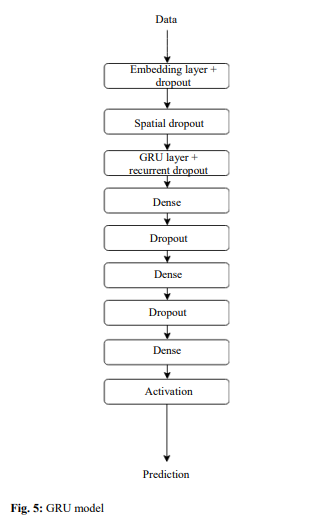

2. https://ariz1623.tistory.com/303 (input iterator 만들기)
3. https://github.com/yellowjs0304/3-min-pytorch_study/blob/master/07-%EC%88%9C%EC%B0%A8%EC%A0%81%EC%9D%B8_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A5%BC_%EC%B2%98%EB%A6%AC%ED%95%98%EB%8A%94_RNN/text_classification.ipynb (rnn and train, evaluate 코드)


